In [1]:
# -----------------------------
# 1. Imports
# -----------------------------
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets import load_from_disk, load_dataset
import torchmetrics
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for path joining

# --- NEW IMPORTS ---
# Make sure to install transformers: pip install transformers
from transformers import AutoModel
import torch.nn.functional as F
# -------------------


/home/pierre/Documents/Projects/PST4/AI/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# 2. Configuration & Setup
# -----------------------------
SEED = 42
BATCH_SIZE = 80
NUM_WORKERS = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 3e-4 # Note: Transformers often prefer smaller LRs (e.g., 3e-5)
                     # But we'll try your original first.
WEIGHT_DECAY = 4e-4
MODEL_SAVE_PATH = "./best_model_transformer.pt" # Changed model name
EPOCHS=10

# --- Set Seeds for Reproducibility ---
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Disabling benchmark mode can help reproducibility
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

print(f"Using device: {DEVICE}")
print(f"Number of workers: {NUM_WORKERS}")

Using device: cuda
Number of workers: 24


In [3]:
# -----------------------------
# 3. Load Dataset
# -----------------------------
# Assuming the dataset is in a directory relative to the notebook
# Using os.path.join for better cross-platform compatibility
# DATASET_PATH = "../dataset/ds_2_noaugment_test.hf"
DATASET_PATH = "../../dataset/ds_2_noaugment_big.hf"
ONLINE_PATH = None

if ONLINE_PATH is None:
    if not os.path.exists(DATASET_PATH):
        print(f"Error: Dataset path not found at {DATASET_PATH}")
        print("Please update the DATASET_PATH variable to point to your dataset directory.")
    else:
        dataset = load_from_disk(DATASET_PATH)
        print("Dataset loaded successfully.")

        # Set format to PyTorch
        dataset = dataset.with_format("torch", columns=["audio", "label"])

        print("\nDataset splits:")
        print({k: v.shape for k, v in dataset.items()})

        print("\nDataset features:")
        print(dataset["train"].features)

Dataset loaded successfully.

Dataset splits:
{'train': (617500, 2), 'val': (78726, 2), 'test': (78483, 2)}

Dataset features:
{'audio': List(List(Value('float64'))), 'label': ClassLabel(names=['other', 'drone'])}


In [4]:
import torchaudio.transforms as T
spec_augmentations = nn.Sequential(
    # Mask up to 50 frequency bins
    T.FrequencyMasking(freq_mask_param=5),
    # Mask up to 80 time steps (frames)
    T.TimeMasking(time_mask_param=5)
)

# -----------------------------
# 2. Modified Collate Function
# -----------------------------
# Define a fixed target size for padding/truncating
TARGET_H, TARGET_W = 128, 128

def collate_fn(batch, augment=False): # <-- Added an 'augment' flag
    """
    Prepares a batch for the model.
    1. Pads/truncates spectrograms to a fixed size (TARGET_H, TARGET_W).
    2. Repeats the single channel to 3 channels for the Transformer.
    3. Applies SpecAugment if 'augment' is True.
    """
    xs = [b["audio"] for b in batch]
    ys = [b["label"] for b in batch]

    # Stack spectrograms: list of (H, W) -> (B, H, W)
    xs_stacked = torch.stack(xs, dim=0)

    # Add channel dim: (B, H, W) -> (B, 1, H, W)
    xs_stacked = xs_stacked.unsqueeze(1)

    # --- NEW: PAD/TRUNCATE TO FIXED SIZE ---
    current_h, current_w = xs_stacked.shape[2], xs_stacked.shape[3]

    # Pad/truncate height
    if current_h > TARGET_H:
        xs_processed = xs_stacked[:, :, :TARGET_H, :]
    else:
        pad_h = TARGET_H - current_h
        # Pad tuple is (left, right, top, bottom)
        xs_processed = F.pad(xs_stacked, (0, 0, 0, pad_h), "constant", 0)

    # Pad/truncate width
    if current_w > TARGET_W:
        xs_processed = xs_processed[:, :, :, :TARGET_W]
    else:
        pad_w = TARGET_W - current_w
        xs_processed = F.pad(xs_processed, (0, pad_w, 0, 0), "constant", 0)

    # --- NEW: REPEAT CHANNELS ---
    # (B, 1, 128, 128) -> (B, 3, 128, 128)
    xs_processed = xs_processed.repeat(1, 3, 1, 1)

    # --- APPLY AUGMENTATION ---
    if augment:
        xs_processed = spec_augmentations(xs_processed)
    # --------------------------

    # Convert labels to float and add a dimension for BCEWithLogitsLoss
    # (B,) -> (B, 1)
    ys = torch.tensor(ys, dtype=torch.float32).unsqueeze(1)

    return xs_processed, ys

from functools import partial

train_collate_fn = partial(collate_fn, augment=True)
val_collate_fn = partial(collate_fn, augment=False)

In [5]:
# Create DataLoaders
# We check if 'dataset' was loaded successfully before proceeding
train_loader = DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=train_collate_fn, pin_memory=True)
valid_loader = DataLoader(dataset["val"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=val_collate_fn, pin_memory=True)
test_loader = DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, collate_fn=val_collate_fn, pin_memory=True)

print(f"\nCreated DataLoaders with Batch Size: {BATCH_SIZE}")

# Check a sample batch
try:
    sample_x, sample_y = next(iter(train_loader))
    print(f"Sample batch shape - X: {sample_x.shape}, Y: {sample_y.shape}")
except Exception as e:
    print(f"Could not load a sample batch: {e}")
    print("Check your NUM_WORKERS setting or collate_fn.")


Created DataLoaders with Batch Size: 80
Sample batch shape - X: torch.Size([80, 3, 128, 128]), Y: torch.Size([80, 1])


In [6]:
# ---------------------------------
# 6. MODEL - REPLACED WITH TRANSFORMER
# ---------------------------------
from transformers import AutoModel, AutoConfig # <-- ADD AutoConfig IMPORT

class AudioTransformer(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224", num_labels=1):
        super().__init__()

        # --- START OF MODIFICATION ---

        # 1. Load the configuration for the model
        config = AutoConfig.from_pretrained(model_name)

        # 2. Modify the config to accept our image size
        #    Your collate_fn pads to 128x128
        config.image_size = 128

        # 3. Load the pre-trained model with the MODIFIED config
        #    'ignore_mismatched_sizes=True' is crucial. It tells
        #    transformers to load all weights that match, but
        #    discard the ones that don't (i.e., the positional embeddings).
        #    The model will create new, randomly initialized
        #    positional embeddings for the 128x128 size.
        self.transformer = AutoModel.from_pretrained(
            model_name,
            config=config,
            ignore_mismatched_sizes=True
        )
        # --- END OF MODIFICATION ---

        # Get the hidden size from the model's config
        hidden_size = self.transformer.config.hidden_size

        # Create a new classifier head for binary classification
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, x):
        # x is our preprocessed batch: (B, 3, 128, 128)

        # Pass input through the transformer
        outputs = self.transformer(pixel_values=x)

        # We use the 'pooler_output'
        pooled_output = outputs.pooler_output

        # Pass the [CLS] token representation through our classifier
        logits = self.classifier(pooled_output)

        return logits

# Use this model instead:
model = AudioTransformer().to(DEVICE)

# --- Check model and a sample pass ---
try:
    print("\nModel instantiated:")
    print(model)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Test a forward pass with the sample batch
    model.eval()
    with torch.no_grad():
        sample_out = model(sample_x.to(DEVICE))
        print(f"Sample output shape: {sample_out.shape}")
    model.train() # Set back to train mode
except Exception as e:
    print(f"Error during model instantiation or sample pass: {e}")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model instantiated:
AudioTransformer(
  (transformer): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
 

In [7]:
# -----------------------------
# 7. Loss, Optimizer, & Metric
# -----------------------------
criterion = nn.BCEWithLogitsLoss() # Handles sigmoid internally, more stable
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Use torchmetrics for accuracy (stateful)
metric_acc = torchmetrics.classification.BinaryAccuracy().to(DEVICE)

In [8]:
best_val_acc = 0.0
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

print("\nStarting training...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    metric_acc.reset()

    # Use tqdm for progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")

    for x, y in train_pbar:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

        # Forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_train_loss += loss.item() * x.size(0)
        metric_acc.update(out, y) # Update stateful metric

        train_pbar.set_postfix(loss=loss.item())

    # Step the scheduler
    scheduler.step()

    # Calculate epoch metrics
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_acc = metric_acc.compute().item()

    history["train_loss"].append(epoch_train_loss)
    history["train_acc"].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    metric_acc.reset()

    valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]", unit="batch")

    with torch.no_grad():
        for x, y in valid_pbar:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            out = model(x)
            loss = criterion(out, y)

            running_val_loss += loss.item() * x.size(0)
            metric_acc.update(out, y)

            valid_pbar.set_postfix(loss=loss.item())

    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    epoch_val_acc = metric_acc.compute().item()

    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.4f}")

    # Save the best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✅ Saved new best model to {MODEL_SAVE_PATH} (Val Acc: {best_val_acc:.4f})")

print("\nTraining complete.")


Starting training...


Epoch 1/10 [Valid]: 100%|██████████| 985/985 [01:40<00:00,  9.81batch/s, loss=0.0101] 



Epoch 1/10 | Train Loss: 0.1491 | Train Acc: 0.9462 | Val Loss: 0.1199 | Val Acc: 0.9627
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9627)


Epoch 2/10 [Valid]: 100%|██████████| 985/985 [01:41<00:00,  9.74batch/s, loss=0.0878] 



Epoch 2/10 | Train Loss: 0.0880 | Train Acc: 0.9715 | Val Loss: 0.1000 | Val Acc: 0.9680
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9680)


Epoch 3/10 [Valid]: 100%|██████████| 985/985 [01:41<00:00,  9.73batch/s, loss=0.0178]  



Epoch 3/10 | Train Loss: 0.0750 | Train Acc: 0.9758 | Val Loss: 0.0811 | Val Acc: 0.9760
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9760)


Epoch 4/10 [Valid]: 100%|██████████| 985/985 [01:40<00:00,  9.76batch/s, loss=0.00685] 



Epoch 4/10 | Train Loss: 0.0637 | Train Acc: 0.9796 | Val Loss: 0.0681 | Val Acc: 0.9807
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9807)


Epoch 5/10 [Valid]: 100%|██████████| 985/985 [01:40<00:00,  9.76batch/s, loss=0.0101]  



Epoch 5/10 | Train Loss: 0.0547 | Train Acc: 0.9825 | Val Loss: 0.0688 | Val Acc: 0.9792


Epoch 6/10 [Valid]: 100%|██████████| 985/985 [01:40<00:00,  9.81batch/s, loss=0.0105]  



Epoch 6/10 | Train Loss: 0.0453 | Train Acc: 0.9856 | Val Loss: 0.0629 | Val Acc: 0.9827
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9827)


Epoch 7/10 [Valid]: 100%|██████████| 985/985 [01:40<00:00,  9.79batch/s, loss=0.00182] 



Epoch 7/10 | Train Loss: 0.0373 | Train Acc: 0.9882 | Val Loss: 0.0615 | Val Acc: 0.9844
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9844)


Epoch 8/10 [Valid]: 100%|██████████| 985/985 [01:40<00:00,  9.80batch/s, loss=0.0411]  



Epoch 8/10 | Train Loss: 0.0304 | Train Acc: 0.9904 | Val Loss: 0.0551 | Val Acc: 0.9861
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9861)


Epoch 9/10 [Valid]: 100%|██████████| 985/985 [01:40<00:00,  9.78batch/s, loss=0.00587] 



Epoch 9/10 | Train Loss: 0.0248 | Train Acc: 0.9923 | Val Loss: 0.0576 | Val Acc: 0.9859


Epoch 10/10 [Valid]: 100%|██████████| 985/985 [01:39<00:00,  9.86batch/s, loss=0.00524] 



Epoch 10/10 | Train Loss: 0.0216 | Train Acc: 0.9934 | Val Loss: 0.0572 | Val Acc: 0.9870
✅ Saved new best model to ./best_model_transformer.pt (Val Acc: 0.9870)

Training complete.


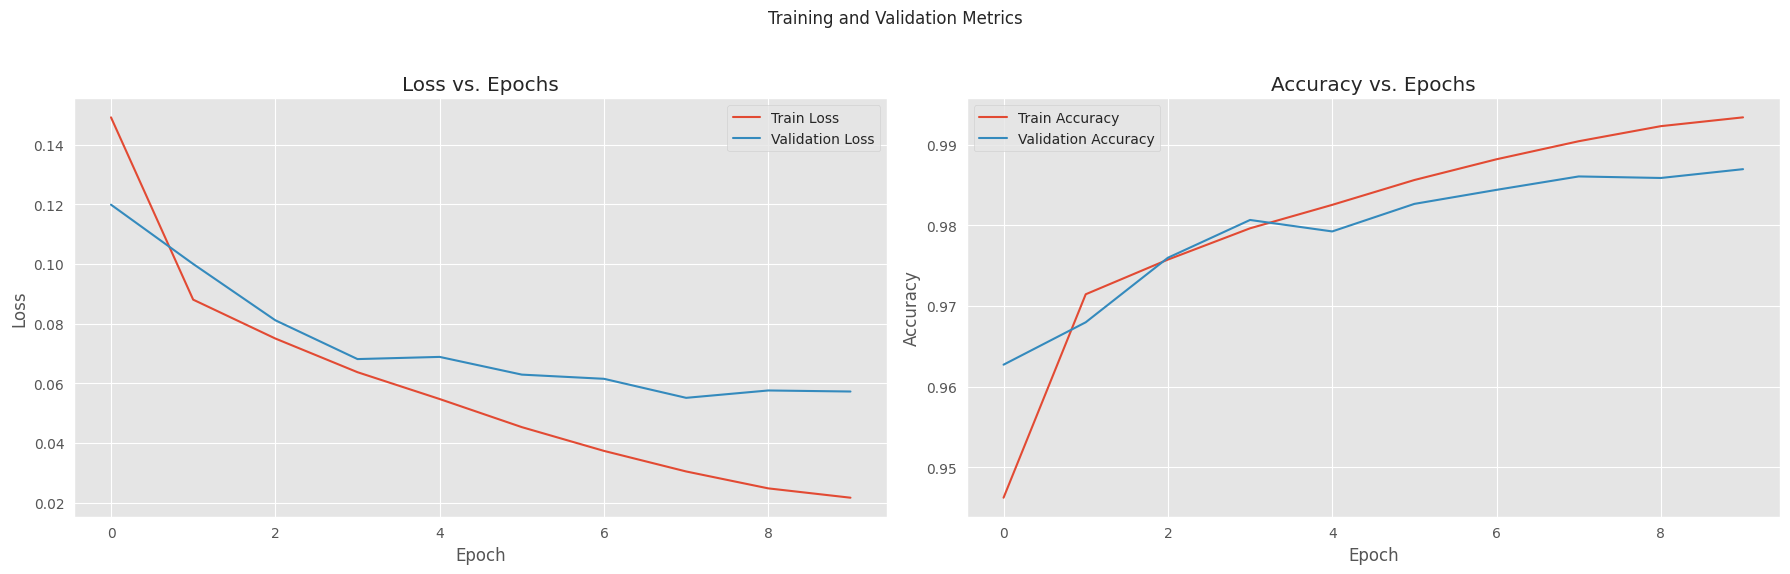

In [9]:
# -----------------------------
# 9. Plot Training History
# -----------------------------
if history["train_loss"]: # Check if training actually ran
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Loss
    ax1.plot(history["train_loss"], label="Train Loss")
    ax1.plot(history["val_loss"], label="Validation Loss")
    ax1.set_title("Loss vs. Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_acc"], label="Train Accuracy")
    ax2.plot(history["val_acc"], label="Validation Accuracy")
    ax2.set_title("Accuracy vs. Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.suptitle("Training and Validation Metrics")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [10]:
print(f"Loading best model from {MODEL_SAVE_PATH}...")
# --- MUST LOAD THE CORRECT MODEL CLASS ---
model = AudioTransformer().to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()
print("Loaded best model and set to eval mode.")

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Apply 0.5 threshold for predictions

        all_preds.extend(preds.cpu().numpy().flatten())
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(y.cpu().numpy().flatten())

print("\nTest evaluation complete.")

Loading best model from ./best_model_transformer.pt...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded best model and set to eval mode.


Testing: 100%|██████████| 982/982 [02:12<00:00,  7.44it/s]


Test evaluation complete.



Test Accuracy: 98.96%

Classification Report:
              precision    recall  f1-score   support

       other      0.991     0.995     0.993     56744
       drone      0.986     0.976     0.981     21739

    accuracy                          0.990     78483
   macro avg      0.989     0.985     0.987     78483
weighted avg      0.990     0.990     0.990     78483



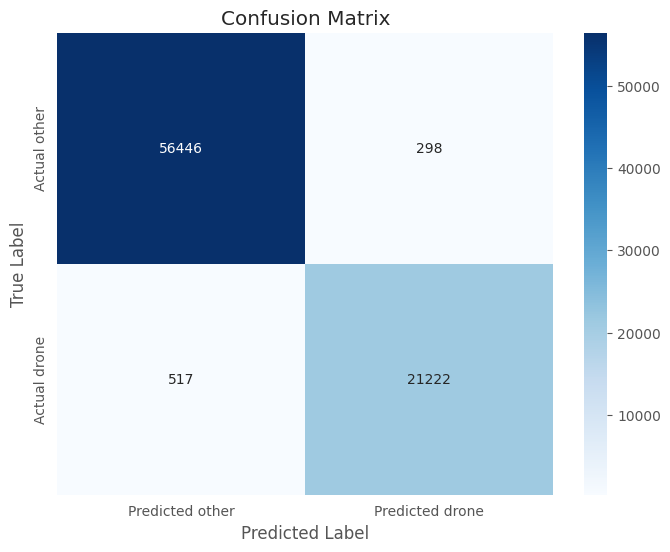


Results DataFrame head:
   true_label  pred_label  confidence
0         1.0         1.0    0.999993
1         1.0         1.0    0.999991
2         1.0         1.0    0.999994
3         1.0         1.0    0.999994
4         0.0         0.0    0.000103


In [11]:
# -----------------------------
# 11. Analyze Test Results
# -----------------------------
# --- Overall Accuracy ---
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# --- Classification Report ---
# Assuming 0 is 'fake' and 1 is 'real', or 'Class 0' and 'Class 1'
# Adjust target_names if you have the actual class names
try:
    # Try to get names from dataset features if they exist
    target_names = dataset["train"].features["label"].names
    if len(target_names) != 2: # Fallback if it's not binary
        target_names = ["Class 0", "Class 1"]
except:
    target_names = ["Class 0", "Class 1"]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=3))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Predicted {target_names[0]}", f"Predicted {target_names[1]}"],
            yticklabels=[f"Actual {target_names[0]}", f"Actual {target_names[1]}"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Store results in a DataFrame (optional) ---
df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

print("\nResults DataFrame head:")
print(df_results.head())

In [8]:
from matplotlib import pyplot as plt
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
ds_test_online2 = load_dataset("Usernameeeeee/drone_test_2", split="test")

def swap_labels(example):
    example["label"] = 1 - example["label"]   # flips 0 ↔ 1
    return example

ds_test_online = ds_test_online.map(swap_labels)
ds_test_online2 = ds_test_online2.map(swap_labels)

# -------------------------------------------------------------------
# --- MODIFIED: CONVERT TO MEL SPECTROGRAM, NOT LINEAR ---
# This ensures the data format (128 bins) matches your training data
# and is compatible with the new Transformer model.
# -------------------------------------------------------------------
import librosa

def convert_to_melspectrogram(batch):
    all_mel_db = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        data = np.array(audio["array"])
        sr = audio["sampling_rate"]

        # --- FIX: convertir en float32 ---
        data = data.astype(np.float32)

        # Compute Mel Spectrogram
        # Use n_mels=128 to match your original dataset
        S = librosa.feature.melspectrogram(
            y=data,
            sr=sr,
            n_fft=2048,
            hop_length=512,
            n_mels=128
        )

        # Convert to dB
        mel_db = librosa.power_to_db(S, ref=np.max)

        all_mel_db.append(mel_db)
        all_labels.append(label)

    return {
        "audio": all_mel_db,
        "label": all_labels,
    }

# -------------------------------------------------------------------

NUM_PROC = 4
# This should exist from the 'dataset' object loaded earlier
LABELS = dataset["train"].features["label"]

ds_test_online_spec = ds_test_online.map(
    convert_to_melspectrogram, # Use new function
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=ds_test_online.column_names,
).with_format("torch")

ds_test_online2_spec = ds_test_online2.map(
    convert_to_melspectrogram, # Use new function
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=ds_test_online2.column_names,
).with_format("torch")

# Use the 'val_collate_fn' which does padding/truncating but NO augmentation
test_loader1 = DataLoader(ds_test_online_spec, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=val_collate_fn)

test_loader2 = DataLoader(ds_test_online2_spec, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=val_collate_fn)

y_true1, y_pred1, y_true2, y_pred2 = [], [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader1, desc="Testing Online Set 1"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred1.extend(preds.cpu().numpy().flatten()) # flatten predictions
        y_true1.extend(y.cpu().numpy().flatten()) # flatten labels

with torch.no_grad():
    for x, y in tqdm(test_loader2, desc="Testing Online Set 2"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred2.extend(preds.cpu().numpy().flatten()) # flatten predictions
        y_true2.extend(y.cpu().numpy().flatten()) # flatten labels



Testing Online Set 2: 100%|██████████| 36/36 [00:05<00:00,  6.56it/s]


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = float("nan")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "confusion_matrix": cm,
    }

metrics1 = compute_metrics(y_true1, y_pred1)
metrics2 = compute_metrics(y_true2, y_pred2)

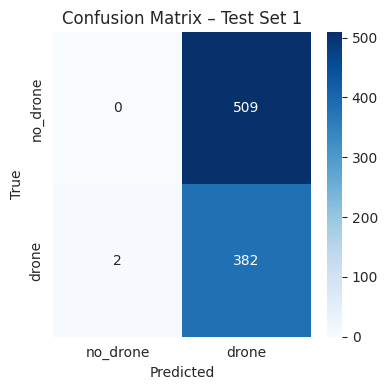

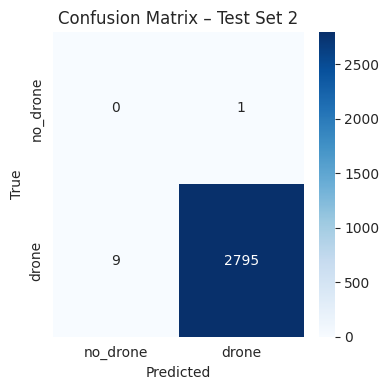

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["no_drone", "drone"]

def plot_confusion(cm, title):
    # Check if confusion matrix is empty or not 2x2
    if cm.shape != (2, 2):
        print(f"Skipping plot for '{title}': Confusion matrix is not 2x2 (shape: {cm.shape}).")
        print("This can happen if the model only predicted one class for this dataset.")
        return

    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(metrics1["confusion_matrix"], "Confusion Matrix – Test Set 1")
plot_confusion(metrics2["confusion_matrix"], "Confusion Matrix – Test Set 2")